In [1]:
import time
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold



def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)


/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
device

'cuda'

In [3]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [4]:
train_features.cp_time.unique(), train_features.cp_type.unique(),  train_features.cp_dose.unique()

(array([24, 72, 48]),
 array(['trt_cp', 'ctl_vehicle'], dtype=object),
 array(['D1', 'D2'], dtype=object))

In [5]:
train_features.shape, test_features.shape

((23814, 876), (3982, 876))

In [6]:
ignore_columns = ['sig_id', "cp_type"]

train_columns = [x for x in train_features.columns if x not in ignore_columns]

train = train_features[train_columns]
test = test_features[train_columns]
target = train_targets_scored.iloc[:,1:].values

In [7]:
train.shape, test.shape, target.shape

((23814, 874), (3982, 874), (23814, 206))

In [8]:
transform = ColumnTransformer([
                            ('o',OneHotEncoder(),[0,1]),
                            ('s',Normalizer(),list(range(3,train.shape[1])))
                        ])


train = transform.fit_transform(train)
test = transform.transform(test)

In [9]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float() 
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [11]:

        
        
class Model(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        super(Model,self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.utils.weight_norm(nn.Linear(input_size,hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.6)
        self.linear2 = nn.utils.weight_norm(nn.Linear(hidden_size,hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.6)
        self.linear3 = nn.utils.weight_norm(nn.Linear(hidden_size,output_size))
        
    def forward(self,xb):
        x = self.batch_norm1(xb)
        x = self.dropout1(x)
        x = F.leaky_relu(self.linear1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.linear2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        return self.linear3(x)

    
    





In [12]:

def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

        if validate == True:
            with torch.no_grad():
                model.eval()
                val_losses_temp = []
                for x_val, y_val in val_loader:
                    yhat =model(x_val.to(device))  # pred 
                    val_loss = criterion(yhat.to(device), y_val.to(device))
                    val_losses_temp.append(val_loss.item())  ## metrics 
                val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            scheduler.step(1.)   ## lr decay caller 
            learning_rates.append(get_lr(optimizer))



        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]

                name = "./model_" + str(fold_number)+".pth"

                print("saving model as: ", name)

                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    return losses, val_losses

In [13]:
## building folds 

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CEND  = '\33[0m'


NFOLDS =5
kfold = KFold(NFOLDS,shuffle=True,random_state=42)
fold_train_losses = list()
fold_valid_losses = list()

num_epochs = 3

for k , (train_idx,valid_idx) in enumerate(kfold.split(train)):

    x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]
    
    
    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True, num_workers = 8)
    
    model = Model(input_size, output_size, hidden_size = 512)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.8e-3)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.5, 
                                                     patience=5, 
                                                     eps=1e-5, 
                                                     verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    print("fold ", str(k+1))

    train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
print(CBLUE, "Training complete", CEND)

fold  1
epoch  1  out of  3      > Val loss decreased from: 1000000  to  0.6920276284217834    >saving model as:  ./model_1.pth
epoch  2  out of  3      > Val loss decreased from: 0.6920276284217834  to  0.042478304356336594    >saving model as:  ./model_1.pth
epoch  3  out of  3      > Val loss decreased from: 0.042478304356336594  to  0.022082189098000526    >saving model as:  ./model_1.pth
fold  2
epoch  1  out of  3      > Val loss decreased from: 1000000  to  0.6931414604187012    >saving model as:  ./model_2.pth
epoch  2  out of  3      > Val loss decreased from: 0.6931414604187012  to  0.04332802817225456    >saving model as:  ./model_2.pth
epoch  3  out of  3      > Val loss decreased from: 0.04332802817225456  to  0.021770842373371124    >saving model as:  ./model_2.pth
fold  3
epoch  1  out of  3      > Val loss decreased from: 1000000  to  0.6947375535964966    >saving model as:  ./model_3.pth
epoch  2  out of  3      > Val loss decreased from: 0.6947375535964966  to  0.0413

In [25]:
all_models = [Model(input_size, output_size , 512) for i in range (NFOLDS)]

for i in range (len(all_models)):
    
    name = "./model_" + str(i + 1) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)



Loaded:  ./model_1.pth
Loaded:  ./model_2.pth
Loaded:  ./model_3.pth
Loaded:  ./model_4.pth
Loaded:  ./model_5.pth


In [26]:
all_val_losses = []
for i in range(NFOLDS):
    losses, val_losses = train_one_fold(all_models[i],5 , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 0, train = False, validate = True)
    all_val_losses.append(np.mean(np.array(val_losses)))

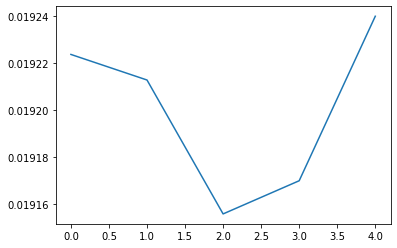

In [118]:
plt.plot(all_val_losses)
# plt.ylim(0.013,0.02)

In [105]:
class model_jury(object):   ## only works for dataloaders for batch size 1 
    def __init__(self, all_models):
        self.all_models = all_models
        
        
        
    def predict(self, x, plot = False):
        
        with torch.no_grad():
            preds = [self.all_models[i](x.to(device)).view(-1).cpu().tolist() for i in range(len(self.all_models))]
        
        if plot == True:
            for pred in preds:
                plt.plot(pred)
            plt.show()
            
        preds = np.array(preds)
        mean = np.mean(preds, axis = 0)
        return mean.flatten()

In [106]:
jury = model_jury(all_models)

In [107]:
test_dataset = TrainDataset(test, target, noise = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [109]:
list_of_preds = []
for batch in tqdm(test_loader):
    x, y = batch
    
    foo = jury.predict(x, plot = False)
    list_of_preds.append(foo)


In [119]:
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

In [120]:
import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

In [121]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,-5.679960,-5.628830,-5.634180,-4.666551,-4.121871,-5.306041,-5.552208,-4.974575,-5.668497,-4.092396,...,-5.765751,-5.528400,-5.410370,-4.321980,-5.317147,-5.721891,-4.458188,-5.583466,-5.584235,-5.631935
1,-5.727033,-5.621867,-5.590736,-5.025705,-4.662688,-5.222306,-5.558617,-5.027584,-5.553468,-4.396370,...,-5.573226,-5.398426,-5.494564,-3.813975,-5.040711,-5.606177,-4.321869,-5.634780,-5.442592,-5.482084
2,-6.046939,-6.217653,-5.983761,-5.020549,-4.778184,-5.734206,-5.707179,-5.624209,-6.067981,-4.872532,...,-6.055518,-6.119366,-5.866686,-5.235461,-5.903933,-6.121309,-5.717096,-5.902942,-5.789285,-5.825858
3,-5.862432,-5.826532,-5.779856,-4.960424,-4.677885,-5.357684,-5.693943,-5.158955,-5.753490,-4.549016,...,-5.826924,-5.693624,-5.607389,-4.077273,-5.302030,-5.828968,-4.485175,-5.755053,-5.591357,-5.612889
4,-5.980521,-6.269011,-6.043952,-5.057303,-4.746848,-5.932042,-5.787375,-5.742365,-6.221155,-4.850810,...,-6.212705,-6.233780,-5.904562,-5.864781,-6.126331,-6.203797,-6.207918,-5.976230,-5.991645,-6.031420


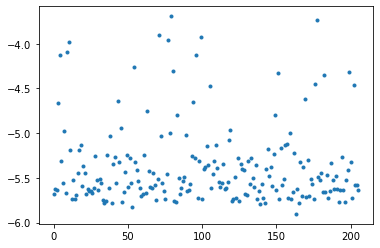

In [122]:
plt.plot(final_sub.values[0], ".")

In [123]:
final_sub = pd.read_csv('./submission_cp.csv', header = None)
final_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,-5.679960,-5.628830,-5.634180,-4.666551,-4.121871,-5.306041,-5.552208,-4.974575,-5.668497,-4.092396,...,-5.765751,-5.528400,-5.410370,-4.321980,-5.317147,-5.721891,-4.458188,-5.583466,-5.584235,-5.631935
1,-5.727033,-5.621867,-5.590736,-5.025705,-4.662688,-5.222306,-5.558617,-5.027584,-5.553468,-4.396370,...,-5.573226,-5.398426,-5.494564,-3.813975,-5.040711,-5.606177,-4.321869,-5.634780,-5.442592,-5.482084
2,-6.046939,-6.217653,-5.983761,-5.020549,-4.778184,-5.734206,-5.707179,-5.624209,-6.067981,-4.872532,...,-6.055518,-6.119366,-5.866686,-5.235461,-5.903933,-6.121309,-5.717096,-5.902942,-5.789285,-5.825858
3,-5.862432,-5.826532,-5.779856,-4.960424,-4.677885,-5.357684,-5.693943,-5.158955,-5.753490,-4.549016,...,-5.826924,-5.693624,-5.607389,-4.077273,-5.302030,-5.828968,-4.485175,-5.755053,-5.591357,-5.612889
4,-5.980521,-6.269011,-6.043952,-5.057303,-4.746848,-5.932042,-5.787375,-5.742365,-6.221155,-4.850810,...,-6.212705,-6.233780,-5.904562,-5.864781,-6.126331,-6.203797,-6.207918,-5.976230,-5.991645,-6.031420


In [124]:
final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]


In [125]:
good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [126]:
final_sub.to_csv("./submission.csv", index=False)
final_sub

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,-5.679960,-5.628830,-5.634180,-4.666551,-4.121871,-5.306041,-5.552208,-4.974575,-5.668497,...,-5.765751,-5.528400,-5.410370,-4.321980,-5.317147,-5.721891,-4.458188,-5.583466,-5.584235,-5.631935
1,id_001897cda,-5.727033,-5.621867,-5.590736,-5.025705,-4.662688,-5.222306,-5.558617,-5.027584,-5.553468,...,-5.573226,-5.398426,-5.494564,-3.813975,-5.040711,-5.606177,-4.321869,-5.634780,-5.442592,-5.482084
2,id_002429b5b,-6.046939,-6.217653,-5.983761,-5.020549,-4.778184,-5.734206,-5.707179,-5.624209,-6.067981,...,-6.055518,-6.119366,-5.866686,-5.235461,-5.903933,-6.121309,-5.717096,-5.902942,-5.789285,-5.825858
3,id_00276f245,-5.862432,-5.826532,-5.779856,-4.960424,-4.677885,-5.357684,-5.693943,-5.158955,-5.753490,...,-5.826924,-5.693624,-5.607389,-4.077273,-5.302030,-5.828968,-4.485175,-5.755053,-5.591357,-5.612889
4,id_0027f1083,-5.980521,-6.269011,-6.043952,-5.057303,-4.746848,-5.932042,-5.787375,-5.742365,-6.221155,...,-6.212705,-6.233780,-5.904562,-5.864781,-6.126331,-6.203797,-6.207918,-5.976230,-5.991645,-6.031420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,-6.120609,-6.029621,-6.076323,-5.671113,-5.435343,-5.909560,-6.110951,-5.806555,-5.980929,...,-6.079699,-5.712262,-5.953594,-3.601126,-5.541431,-6.055966,-4.649351,-6.066265,-6.044125,-5.947447
3978,id_ff925dd0d,-5.804338,-6.027048,-5.967618,-4.978369,-4.265625,-5.740501,-5.606171,-5.475812,-6.117903,...,-6.143017,-6.083321,-5.804624,-6.088103,-6.104084,-6.062685,-6.022762,-5.869178,-5.880138,-5.989139
3979,id_ffb710450,-5.921171,-6.007148,-5.969432,-5.031055,-4.241337,-5.350413,-5.561746,-5.249198,-5.990728,...,-5.954805,-5.951075,-5.854402,-5.676965,-5.750247,-5.997140,-5.708962,-5.886610,-5.703576,-5.803680
3980,id_ffbb869f2,-5.901772,-5.928934,-5.872447,-5.050678,-4.389804,-5.599361,-5.518376,-5.399906,-5.866856,...,-6.018552,-5.951058,-5.599330,-4.957850,-5.508211,-5.966712,-4.853144,-5.817910,-5.780413,-5.770779
